In [137]:
#install yahoo finance if you donot have it
#!pip uninstall yfinance
#!pip install yfinance --upgrade --no-cache-dir

In [2]:
import numpy as np
import pandas as pd
#Data Source
import yfinance as yf
#Data viz
import plotly.graph_objs as go
import matplotlib.pyplot as plt

X        MA3   MA5
4  11  10.666667  11.6
5  10  10.333333  10.8
6  11  10.666667  10.6
7  15  12.000000  11.4
8  17  14.333333  12.8
9  18  16.666667  14.2

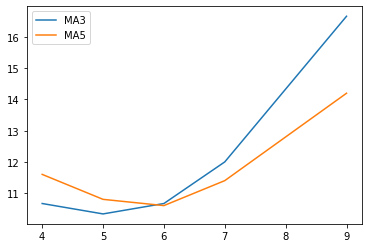

In [3]:
data = pd.DataFrame({'X': [14,12,11,10,11,10,11,15,17,18]})
data["MA3"] =data["X"].rolling(3).mean()
data["MA5"] =data["X"].rolling(5).mean()
data = data[4:]
#plt.plot(data["X"],label="x")
plt.plot(data["MA3"],label="MA3")
plt.plot(data["MA5"],label="MA5")
plt.legend()
data

In [4]:
day_datas = {}
days = [10,20,30,50,80,100,120]
for day in days:
  data = yf.download(tickers='BTC-USD', period = str(day)+'d', interval = '1h')
  day_datas[day] = data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
day_datas[120]

Open          High           Low  \
2021-06-04 00:00:00+01:00  38908.632812  39255.164062  38864.371094   
2021-06-04 01:00:00+01:00  39242.484375  39242.484375  38652.214844   
2021-06-04 02:00:00+01:00  38699.515625  38699.515625  37734.828125   
2021-06-04 03:00:00+01:00  37906.570312  37906.570312  37456.257812   
2021-06-04 04:00:00+01:00  37816.714844  38118.128906  37654.933594   
...                                 ...           ...           ...   
2021-10-01 11:00:00+01:00  44915.625000  47604.625000  44872.824219   
2021-10-01 12:00:00+01:00  47126.742188  47621.785156  47011.238281   
2021-10-01 13:00:00+01:00  47503.265625  47803.511719  47213.003906   
2021-10-01 14:00:00+01:00  47214.269531  47355.804688  47054.730469   
2021-10-01 14:46:02+01:00  47116.402344  47116.402344  47116.402344   

                                  Close     Adj Close      Volume  
2021-06-04 00:00:00+01:00  39208.765625  39208.765625           0  
2021-06-04 01:00:00+01:00  38684.769531  38684.769531           0  
2021-06-04 02:00:00+01:00  37837.148438  37837.148438  1561051136  
2021-06-04 03:00:00+01:00  37807.812500  37807.812500   824967168  
2021-06-04 04:00:00+01:00  37953.734375  37953.734375   575926272  
...                                 ...           ...         ...  
2021-10-01 11:00:00+01:00  47178.023438  47178.023438  5899962368  
2021-10-01 12:00:00+01:00  47481.683594  47481.683594  1823952896  
2021-10-01 13:00:00+01:00  47237.945312  47237.945312   861618176  
2021-10-01 14:00:00+01:00  47067.371094  47067.371094   398446592  
2021-10-01 14:46:02+01:00  47116.402344  47116.402344           0  

[2867 rows x 6 columns]

In [6]:
#declare figure
fig = go.Figure()

data = day_datas[120]
#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Bitcoin live share price evolution',
    yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=6, label="6h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Show
fig.show()

In [132]:


def get_weights(period,exponential_part):
  ws = np.arange(1,period+1,  1) **exponential_part
  ws =  ws / ws.sum()
  return ws

def get_rolling_weighted(df,target_col,weights):
  return df[target_col].rolling(len(weights)).apply(lambda x: np.sum(weights*x))

def get_rolling_mean(df,target_col,period,exponential_part):
  #normal mean
  if exponential_part == 1: 
    return df[target_col].rolling(period).mean()
  else:
    weights = get_weights(period,exponential_part)
    return get_rolling_weighted(df,target_col,weights)  


def draw_for_roll(df,col,rolls,day,exponential_part,draw_rolls=False):
  df_new = df.copy()
  df_new["returns"] = df_new[col].pct_change()
  holding_perf = (df_new["returns"].shift(-1) + 1).cumprod()  # benchmark

  roll_performances = {}
  for roll in rolls :
    roll1 = roll[0]
    roll2 = roll[1]
    df_new = df.copy()
    df_new["roll1"] = get_rolling_mean(df,col,roll1,exponential_part) #df_new[col].rolling(roll1).mean()
    df_new["roll2"] = get_rolling_mean(df,col,roll2,exponential_part) #df_new[col].rolling(roll2).mean()
    df_new["returns"] = df_new[col].pct_change()
    trades = df_new["roll1"] > df_new["roll2"]
    #shift(-1) * trades + 1
    # Shift the returns up by one: This means that we are just moving the column with our returns up by one day. What this does is to make sure we are not including any bias in our backtest.
    #Adding 1 to the strategy returns and calculating the cumulative product: By doing so we basically sum up the daily returns to get to the overall returns of the strategy over the whole time interval.
    strategy_perf = (df_new["returns"].shift(-1) * trades + 1).cumprod()  # backtesting
    roll_performances[f"Roll {roll1}-{roll2}"] = strategy_perf
    #For last part,when u try your algorithm draw rolls and decide buy or sell by your eyes
    if draw_rolls:
        #print("trades",trades)
        fig = plt.figure( figsize=(20,7)) 
        ax = fig.gca()
        s1 = df_new["roll1"]
        s2 = df_new["roll2"]
        s1.plot(ax=ax,label="short")
        s2.plot(ax=ax,label="long")
        
        plt.style.use('fivethirtyeight')
        
        arrow_dict = dict(arrowstyle = "->", color = "black",
                  connectionstyle = "angle, angleA = 0, angleB =90")
        for trade_index,v in enumerate(trades.values):
            if trade_index > 10:
                xa ,ya =  s1.index[trade_index], s1.iloc[trade_index]
                if trades.values[trade_index] and not trades.values[trade_index -1]:
                    #ax.text(s1.index[trade_index], s1.iloc[trade_index], "Buy",fontsize = 30, color ="green")                                                            
                    ax.annotate('Buy', xy=(xa,ya), xytext=(xa,ya + 2000),
                       arrowprops=dict(facecolor='black', shrink=0.05)) 
                    
                if not trades.values[trade_index] and  trades.values[trade_index -1 ]:                                        
                    ax.annotate('Sell', xy=(xa,ya), xytext=(xa,ya - 2000),
                       arrowprops=dict(facecolor='red', shrink=0.05)) 
                    #ax.text(s1.index[trade_index], s1.iloc[trade_index], "Sell",fontsize = 30, color ="purple")    
        
        
        plt.legend()
        plt.show()
  
  
  line_styles = [ "dotted","dashed","solid","dashdot" ]
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(20,7))
  plt.title(f"For last {day} days Exp :{exponential_part}")
  for index,key in enumerate( roll_performances.keys() ):
    plt.plot(roll_performances[key],label=key,linestyle=line_styles[index % len( line_styles) ])

  plt.plot(holding_perf,label="hold")
  plt.legend()
  plt.show()
  return df_new

def draw_for_daydata(dfs,col,roll,day,exponential_part):
  key0 = list(dfs.keys())[-1]
  df_new = dfs[key0].copy()
  df_new["returns"] = df_new[col].pct_change()
  holding_perf = (df_new["returns"].shift(-1) + 1).cumprod()  # benchmark

  roll_performances = {}
  for day_key in dfs.keys() :
    df = dfs[day_key]
    roll1 = roll[0]
    roll2 = roll[1]
    df_new = df.copy()
    df_new["roll1"] = get_rolling_mean(df,col,roll1,exponential_part) #df_new[col].rolling(roll1).mean()
    df_new["roll2"] = get_rolling_mean(df,col,roll2,exponential_part) #df_new[col].rolling(roll2).mean()
    df_new["returns"] = df_new[col].pct_change()
    trades = df_new["roll1"] > df_new["roll2"]
    strategy_perf = (df_new["returns"].shift(-1) * trades + 1).cumprod()  # backtesting
    roll_performances[f"Day {day_key}"] = strategy_perf
  
  
  line_styles = [ "dotted","dashed","solid","dashdot" ]
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(20,7))
  plt.title(f"For  {roll} Exp :{exponential_part}")
  for index,key in enumerate( roll_performances.keys() ):
    plt.plot(roll_performances[key],label=key,linestyle=line_styles[index % len( line_styles) ])

  plt.plot(holding_perf,label="hold")
  plt.legend()
  plt.show()
  return df_new    

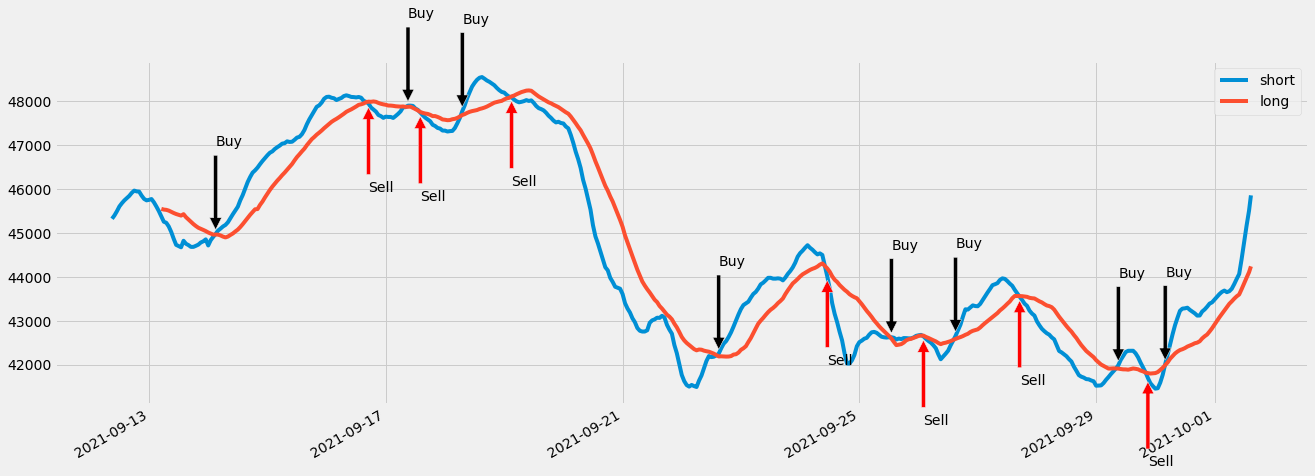

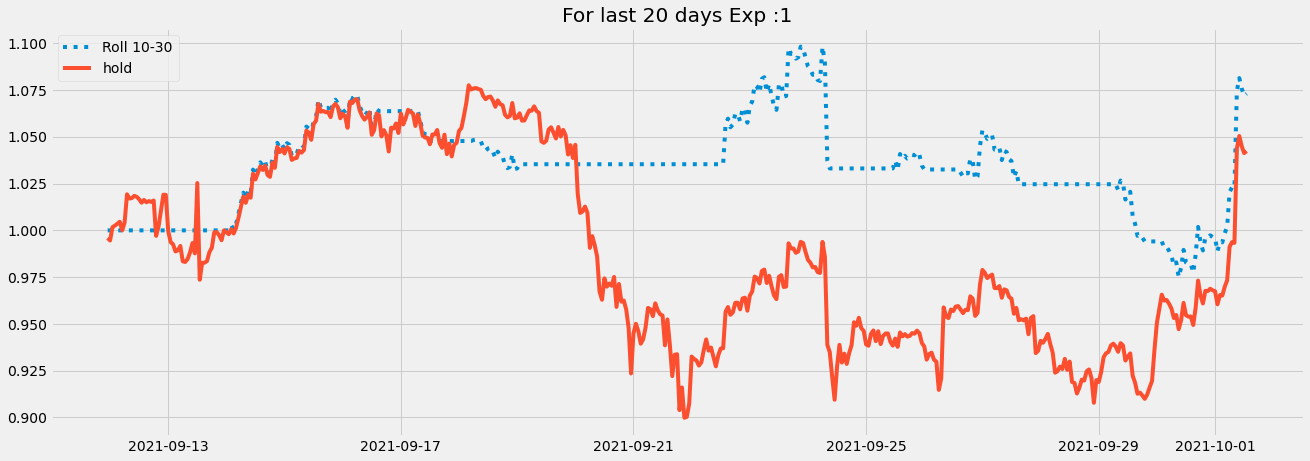

In [29]:
#For a 6 window size, with exp term, how will the weights be,
#more exponential more weight on latest terms
print( get_weights(6,1))  
print( get_weights(6,1.1))  
print( get_weights(6,1.5))  
print( get_weights(6,2))  
print( get_weights(6,3)) 

[0.04761905 0.0952381  0.14285714 0.19047619 0.23809524 0.28571429]
[0.04142984 0.08880681 0.13872241 0.19036156 0.24332138 0.29735801]
[0.02330901 0.06592785 0.12111719 0.18647211 0.2606027  0.34257114]
[0.01098901 0.04395604 0.0989011  0.17582418 0.27472527 0.3956044 ]
[0.00226757 0.01814059 0.06122449 0.14512472 0.28344671 0.48979592]


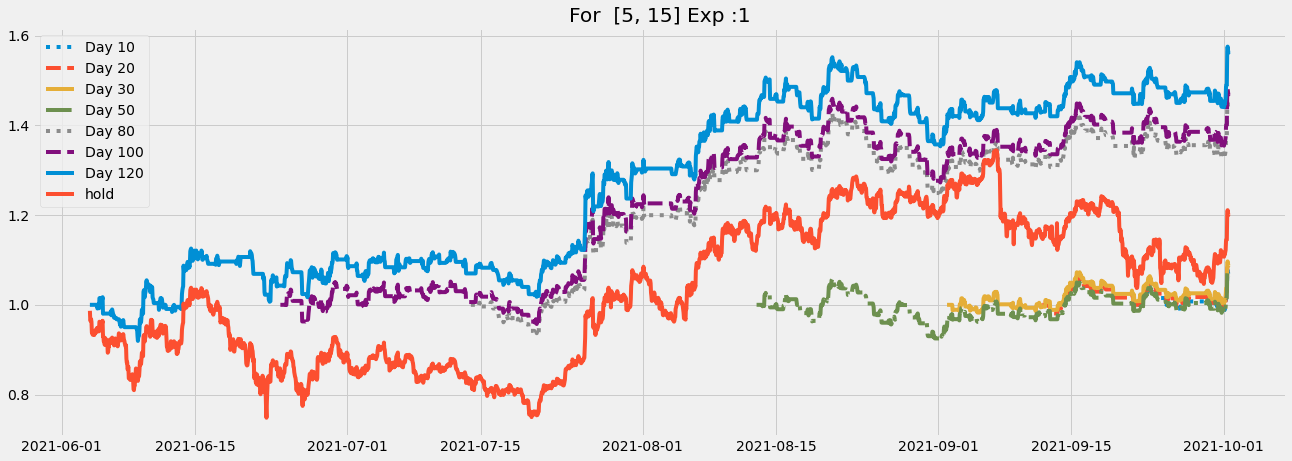

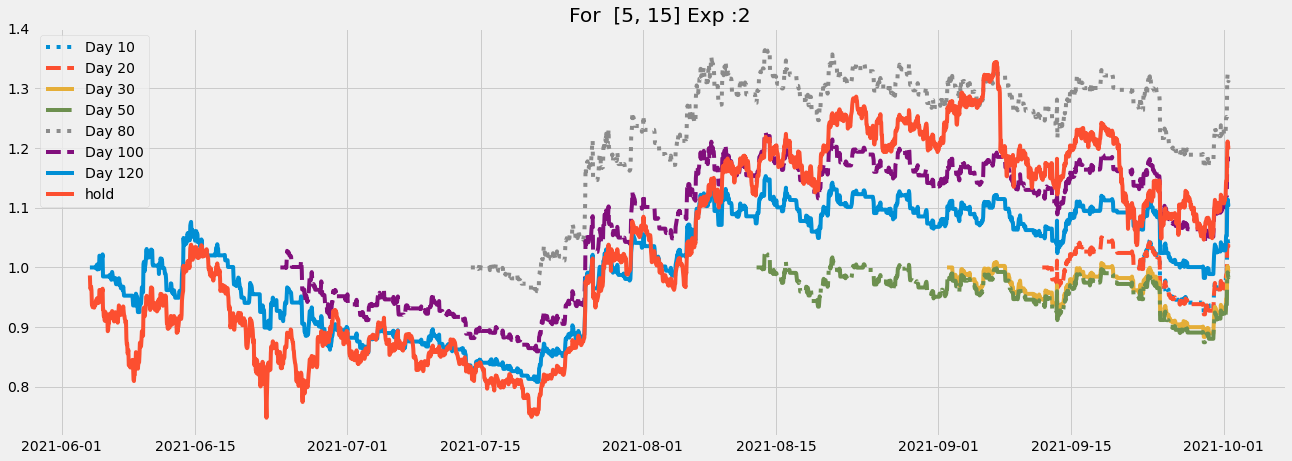

In [30]:
day = 80
ddata = day_datas[day]
draw_for_daydata(day_datas,"Close",[5,15] ,days,exponential_part=1)
_ = draw_for_daydata(day_datas,"Close", [5,15],days,exponential_part=2)  

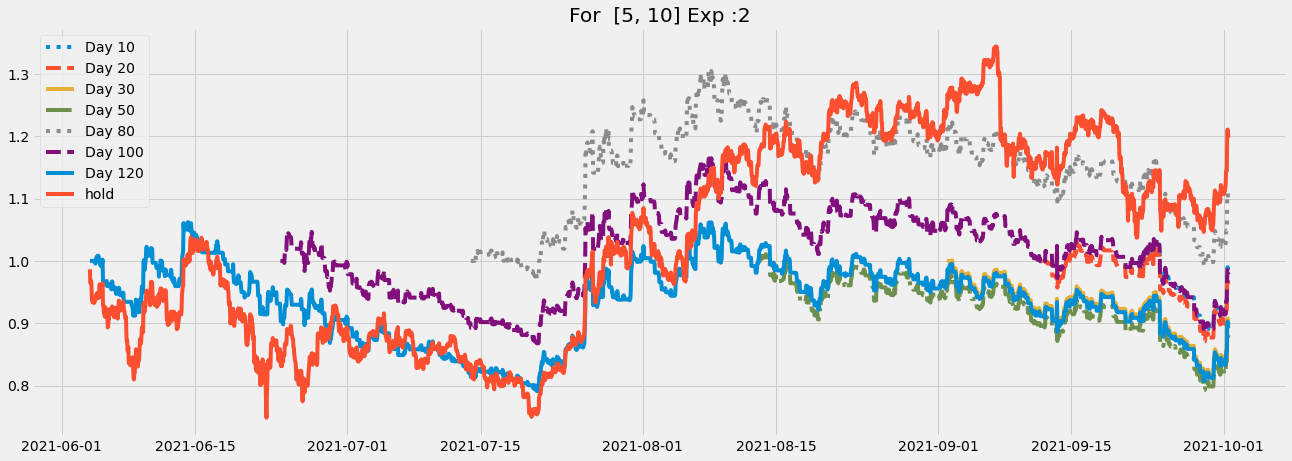

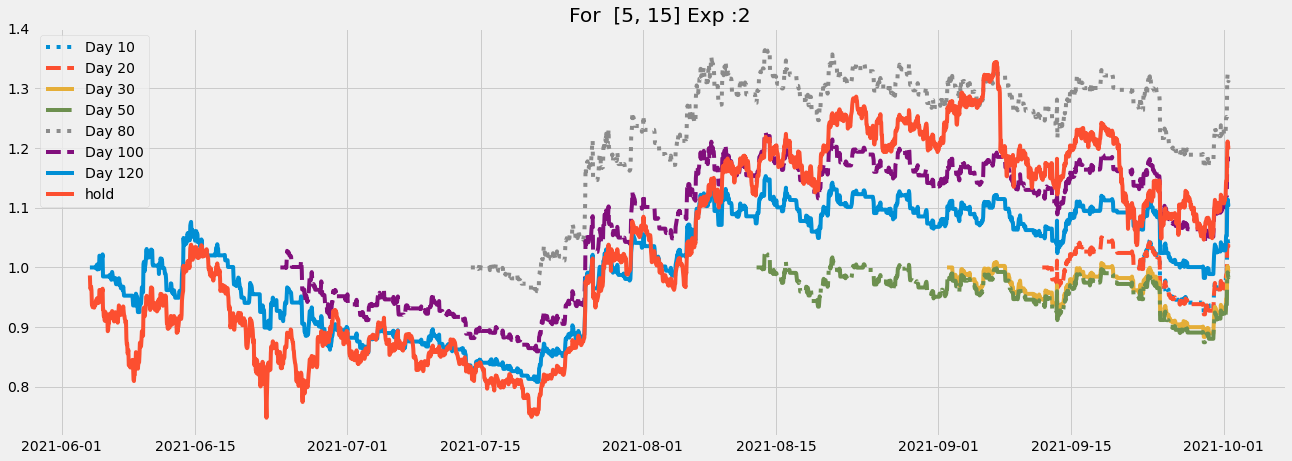

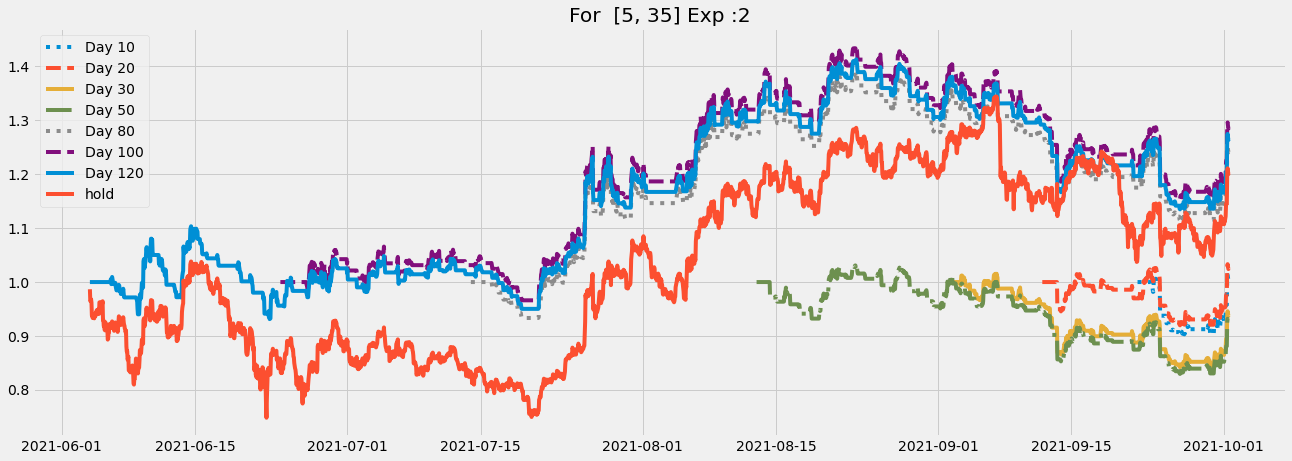

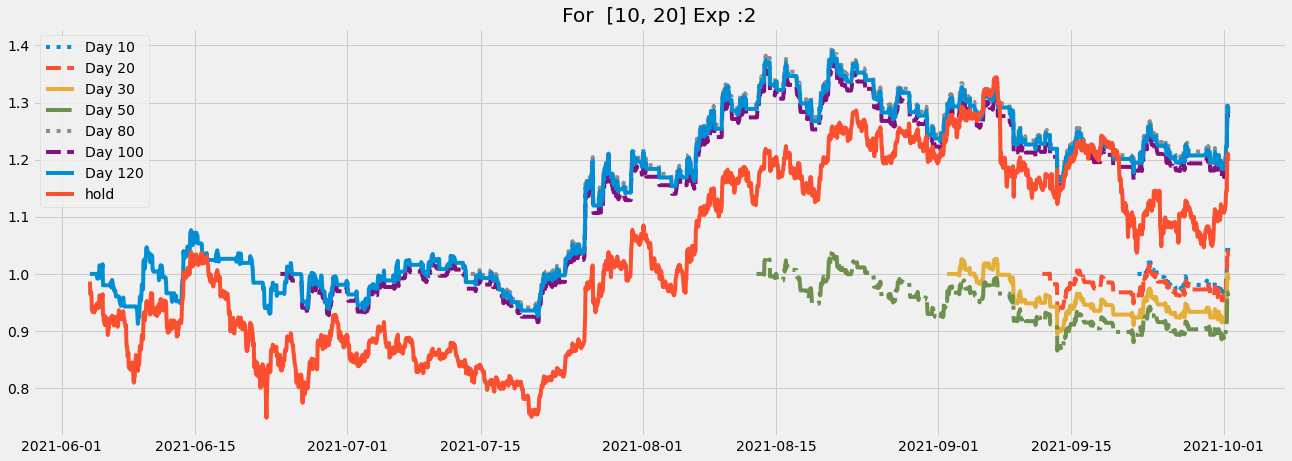

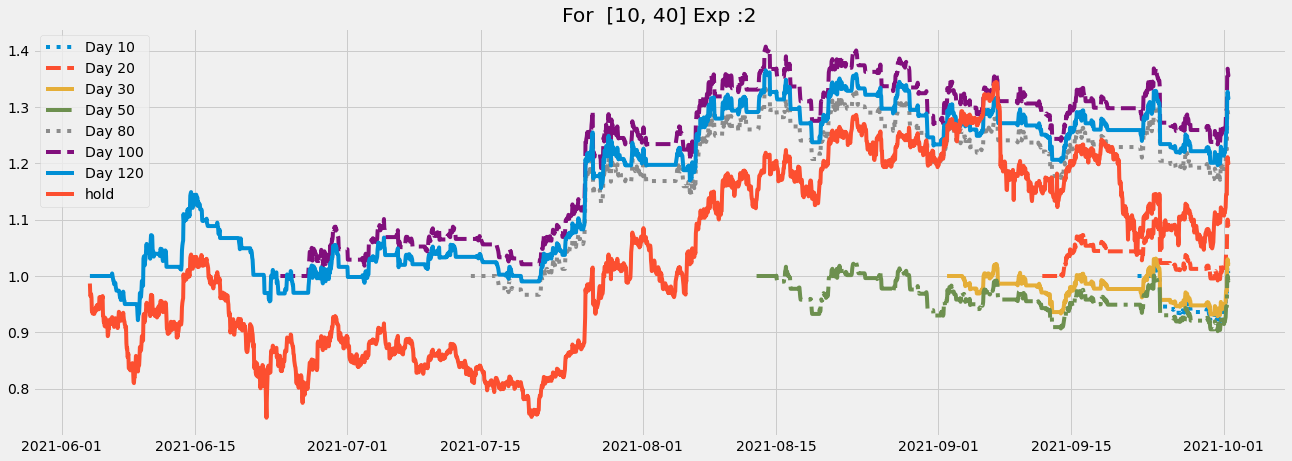

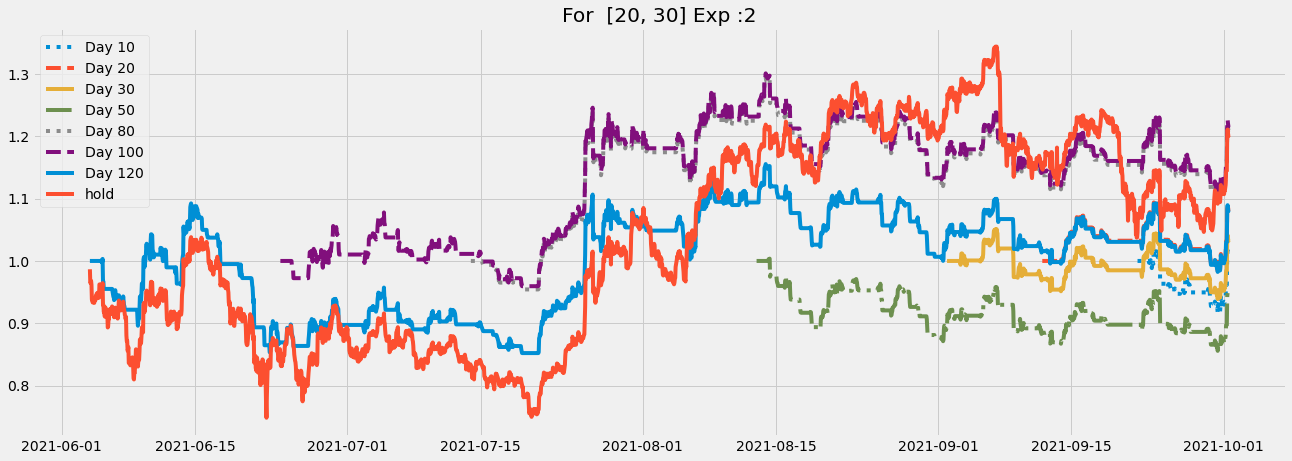

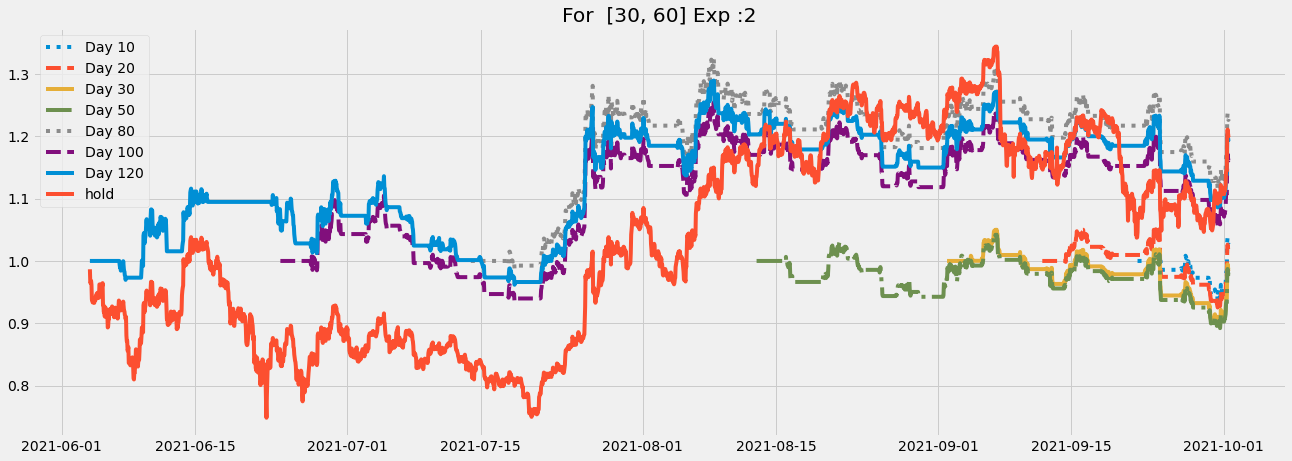

In [31]:
rolls = [ [5,10],[5,15],[5,35],[10,20],[10,40],[20,30],[30,60] ]
for roll in rolls:  
  #ddata = day_datas[day]
  draw_for_daydata(day_datas,"Close",roll,days,exponential_part=2)

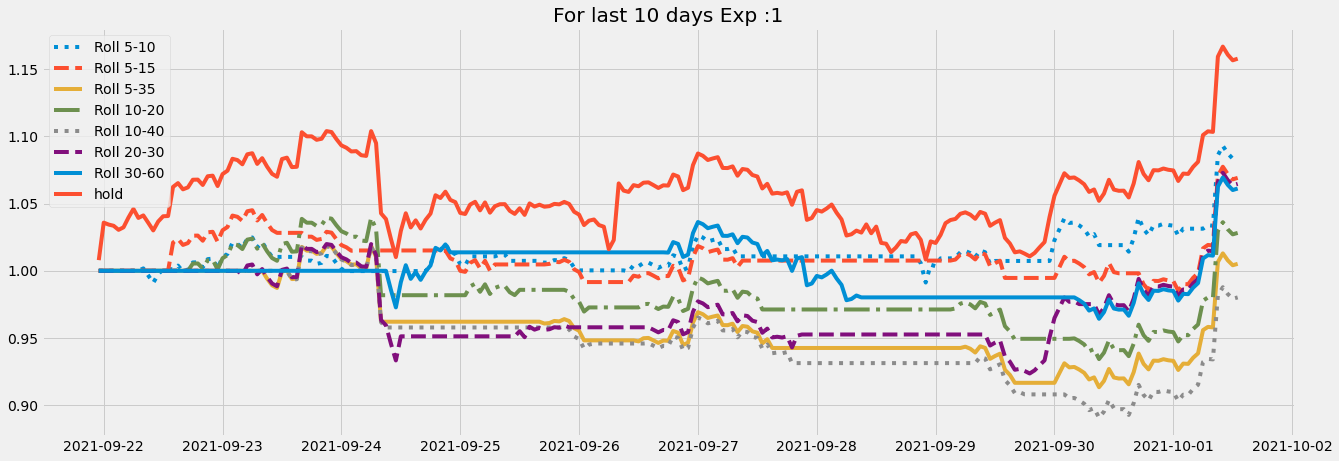

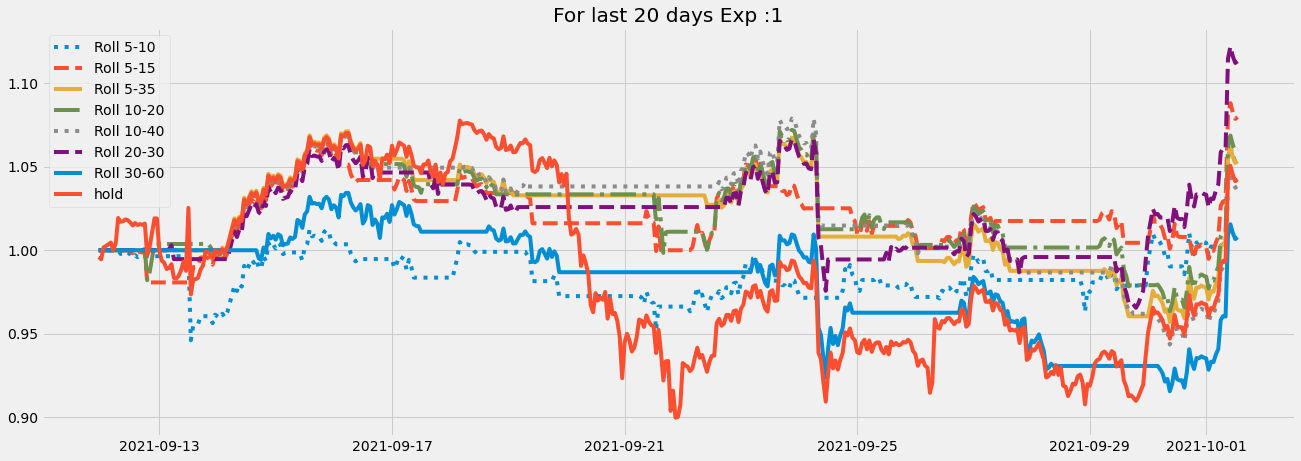

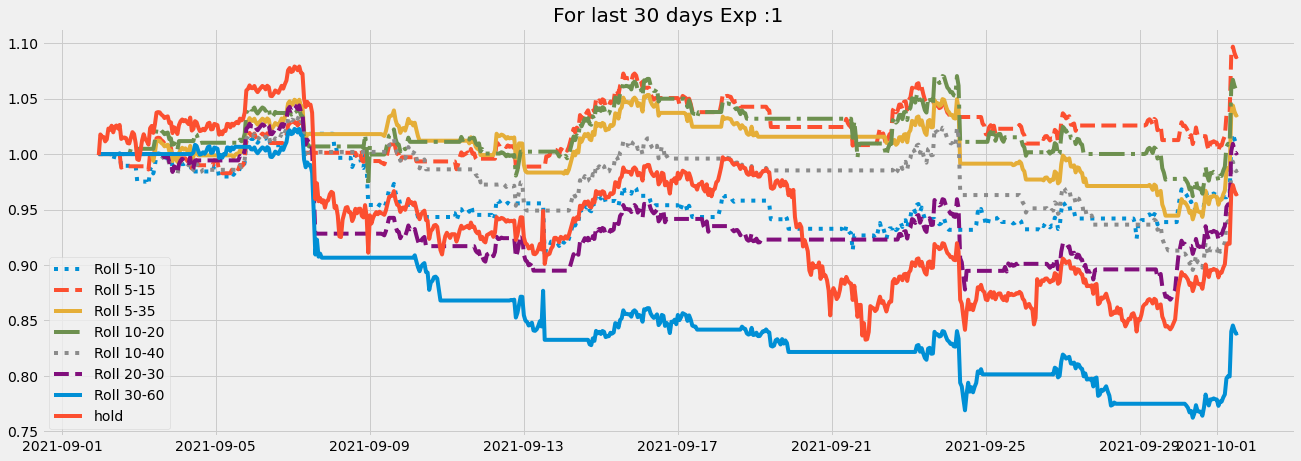

In [32]:
days = [10,20,30]
rolls = [ [5,10],[5,15],[5,35],[10,20],[10,40],[20,30],[30,60] ]
for day in days:  
  ddata = day_datas[day]
  draw_for_roll(ddata,"Close",rolls,day,exponential_part=1)

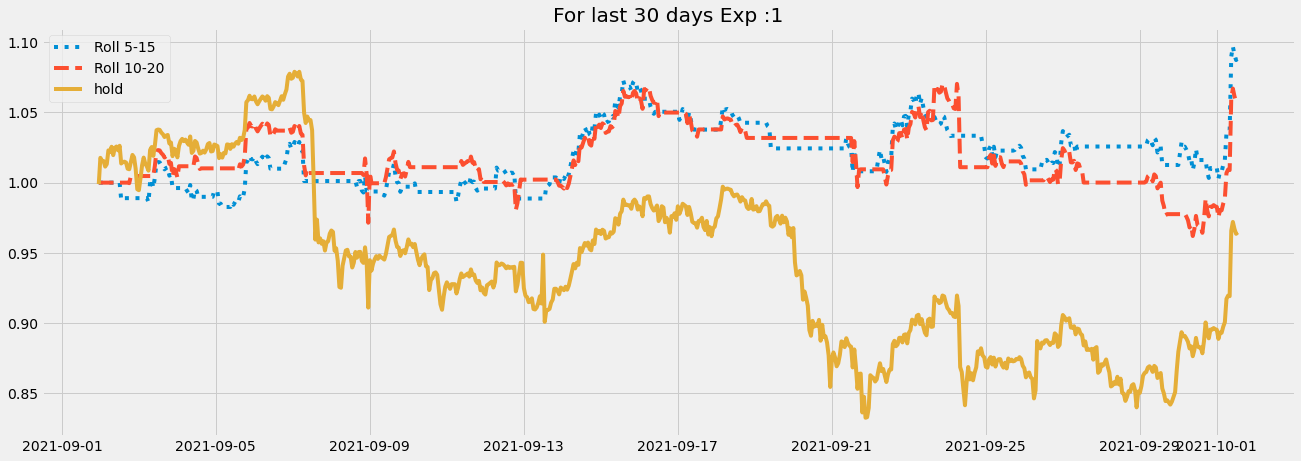

In [33]:
days = [30]
rolls = [ [5,15],[10,20]]
for day in days:  
  ddata = day_datas[day]
  draw_for_roll(ddata,"Close",rolls,day,exponential_part=1,draw_rolls=True)

[*********************100%***********************]  1 of 1 completed


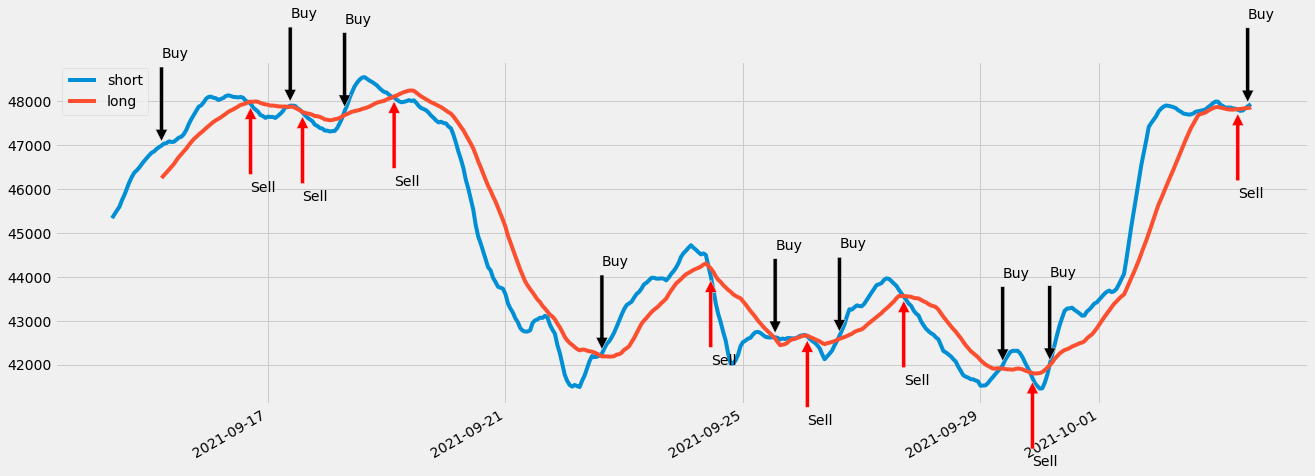

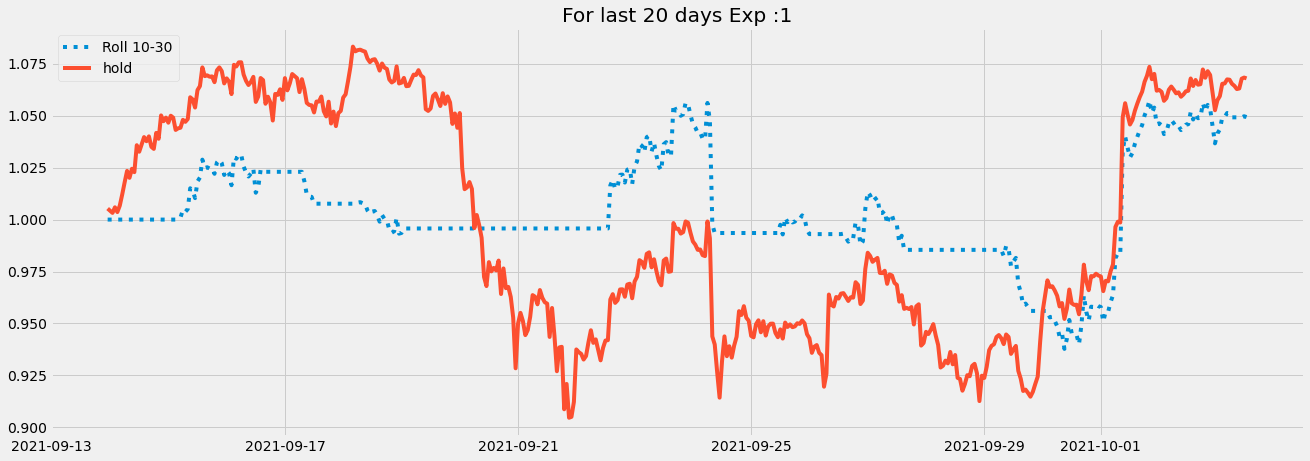

In [136]:
#Run this daily ,do your trade
days = 20
rolls = [ [10,30]]

current_data = yf.download(tickers='BTC-USD', period = str(day)+'d', interval = '1h')
#Download latest data from live
#change exponential_part according to your theory, or change code
#to give weigths manually in code
_ = draw_for_roll(current_data,"Close",rolls,day,exponential_part=1,draw_rolls=True)